This notebook contains all the experimentation work done for the final custom models prepared for talewind's backend.

In [6]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import datetime

# specific imports
from keras.models import Sequential
from keras.layers import LSTMV2, Dense, Dropout, Input
from spacy import displacy
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support
from sentence_transformers import SentenceTransformer
from nltk.tokenize import PunktSentenceTokenizer as pkt
from IPython.display import clear_output
from pprint import pprint

# deprecated imports
from bs4 import BeautifulSoup
from urllib.request import urlopen

MODEL_ID = 'sentence-transformers/all-MiniLM-L6-v2'

In [7]:
df1 = pd.read_csv('./datasets/newsArticlesWithLabels.tsv', delimiter='\t')
df1.head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral


In [8]:
df1.shape

(21004, 7)

In [9]:
url = df1['url'][1]
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")
print(soup.get_text())

Senate Immigration Bill Passes Out Of Judiciary Committee | HuffPost Latest News





Skip to Main Content×Main MenuU.S. EditionNewsU.S. NewsWorld NewsBusinessEnvironmentHealthCoronavirusSocial JusticePoliticsJoe BidenCongressExtremismElections 2022OpinionEntertainmentCulture & ArtsMediaCelebrityTV & FilmLifeStyle & BeautyFood & DrinkParentingTravelWellnessRelationshipsMoneyHome & LivingWork/LifeShoppingVoicesQueer VoicesWomen's VoicesBlack VoicesLatino VoicesAsian VoicesSpecial ProjectsHighlineHuffPost PersonalHoroscopesFrom Our PartnersMemories In The MakingThe Stories Of UsNewslettersInternationalAustraliaBrazilCanadaEspañaFranceΕλλάδα (Greece)IndiaItalia日本 (Japan)한국 (Korea)QuébecU.K.U.S.Follow UsTerms | Privacy PolicyPart of HuffPost Politics. ©2023 BuzzFeed, Inc. All rights reserved.Log InJoin HuffPostNEWSPOLITICSENTERTAINMENTLIFEPERSONALVOICESSHOPPINGVIDEOU.S. EditionOpen editions submenu×What's HotA Woman's Orgasm — Or Was It? — Stole The Show At LA Philharmonic'Daily Show' Gues

### scraping here is way too time consuming and not useful, so we will try the other datasets first.

In [10]:
df2 = pd.read_csv('./datasets/labeled_dataset.csv')
df2.head()

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
3,3,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,1,1,Non-biased,No agreement,A professor who teaches climate change classes...,['legitimate']
4,4,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."


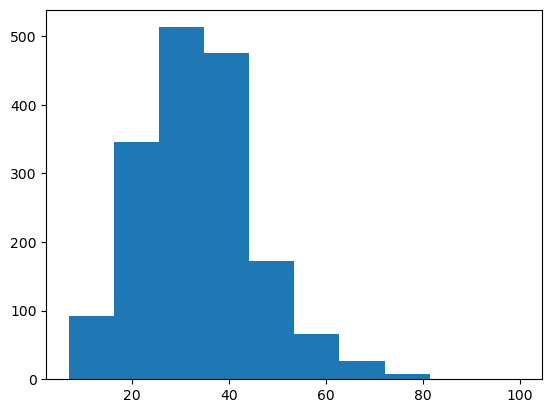

count    1700.000000
mean       33.481765
std        11.933266
min         7.000000
25%        25.000000
50%        33.000000
75%        40.000000
max       100.000000
Name: sentence, dtype: float64


In [11]:
# counting the number of words in sequences.
plt.hist(df2['sentence'].apply(lambda x: len(x.split(' '))))
plt.show()
print(df2['sentence'].apply(lambda x: len(x.split(' '))).describe())

In [12]:
# based on that data, we can safely set the max length of sequences to 128
MAX_LENGTH = 128

In [13]:
onehotencode = pd.get_dummies(df2.iloc[:, 8:10])
nonagree = onehotencode.iloc[:, [1, 5]]

In [14]:
pd.concat([df2['sentence'], onehotencode], axis=1).head()

,sentence,Label_bias_Biased,Label_bias_No agreement,Label_bias_Non-biased,Label_opinion_Entirely factual,Label_opinion_Expresses writer’s opinion,Label_opinion_No agreement,Label_opinion_Somewhat factual but also opinionated
0,YouTube is making clear there will be no “birt...,1,0,0,0,0,0,1
1,The increasingly bitter dispute between Americ...,0,0,1,1,0,0,0
2,So while there may be a humanitarian crisis dr...,1,0,0,0,1,0,0
3,A professor who teaches climate change classes...,0,0,1,0,0,1,0
4,"Looking around the United States, there is nev...",1,0,0,0,0,0,1


In [15]:
onehotencode.sum()

Label_bias_Biased                                      1018
Label_bias_No agreement                                 149
Label_bias_Non-biased                                   533
Label_opinion_Entirely factual                          572
Label_opinion_Expresses writer’s opinion                521
Label_opinion_No agreement                              174
Label_opinion_Somewhat factual but also opinionated     433
dtype: int64

one hot encoding based on combination, to see if the results are better.

In [16]:
combinations = []
for i, j in df2.iloc[:, 8:10].iterrows():
    combinations.append(j[0] + '_' + j[1])
(pd.get_dummies(combinations) == 1).sum()

Biased_Entirely factual                                70
Biased_Expresses writer’s opinion                     491
Biased_No agreement                                   107
Biased_Somewhat factual but also opinionated          350
No agreement_Entirely factual                          64
No agreement_Expresses writer’s opinion                18
No agreement_No agreement                              29
No agreement_Somewhat factual but also opinionated     38
Non-biased_Entirely factual                           438
Non-biased_Expresses writer’s opinion                  12
Non-biased_No agreement                                38
Non-biased_Somewhat factual but also opinionated       45
dtype: int64

- this is not nearly enough data either way, so we will be synthesizing our own dataset to work on for the purposes of this project.

Since i already know what the data structure is going to be like, i can simply already work on the structure of the model and what the output would look like.

In [17]:
sample_dataset = pd.read_csv('./datasets/synthesized_dataset.csv')
sample_dataset.head()

,Sentence,Content Bias,Partisan Bias,False balance,Ventriloquism,Demographic bias,Undue Weight,Corporate
0,The president's speech yesterday was an absolu...,1,1,0,0,0,0,0
1,"Climate change is a controversial issue, with ...",0,0,1,0,0,0,0
2,"In a groundbreaking move, the company announce...",0,0,0,0,1,0,1
3,"Despite widespread opposition, the oil company...",1,0,0,0,0,1,1
4,The senator's recent tweet demonstrates her un...,0,1,0,0,0,0,0


- this is a very small sample of what the dataset would be like. we'll find manual thresholds for what values should flag as biases.

In [18]:
# adding more unbiased samples from the above dataset.
add = df2[df2['Label_bias'] != 'Biased']
arr = np.zeros((len(add), 7), dtype=int)
arr = pd.DataFrame(arr, columns=['Content Bias', 'Partisan Bias', 'False balance', 'Ventriloquism', 
                                 'Demographic bias', 'Undue Weight', 'Corporate'])
add = pd.concat([add['sentence'], arr], axis=1)
add = add.rename(columns={'sentence':'Sentence'})
add = add.dropna()

In [19]:
sample_dataset = pd.concat([sample_dataset, add], axis=0)
sample_dataset.head()

,Sentence,Content Bias,Partisan Bias,False balance,Ventriloquism,Demographic bias,Undue Weight,Corporate
0,The president's speech yesterday was an absolu...,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"Climate change is a controversial issue, with ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"In a groundbreaking move, the company announce...",0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,"Despite widespread opposition, the oil company...",1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,The senator's recent tweet demonstrates her un...,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
sample_dataset.shape

(4299, 8)

In [21]:
print(f"Number of Repeats: {sample_dataset.shape[0] - len(sample_dataset['Sentence'].unique())}")
print(f"Number of Unique Sentences: {len(sample_dataset['Sentence'].unique())}")

Number of Repeats: 2455
Number of Unique Sentences: 1844


In [22]:
sample_dataset.dtypes

Sentence             object
Content Bias        float64
Partisan Bias       float64
False balance       float64
Ventriloquism       float64
Demographic bias    float64
Undue Weight        float64
Corporate           float64
dtype: object

In [23]:
sample_dataset.isna().sum()

Sentence            0
Content Bias        0
Partisan Bias       0
False balance       0
Ventriloquism       0
Demographic bias    0
Undue Weight        0
Corporate           0
dtype: int64

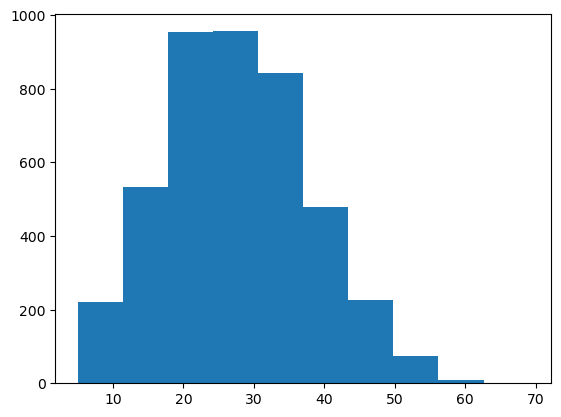

In [24]:
plt.hist(sample_dataset['Sentence'].apply(lambda x: len(x.split(' '))))
plt.show()

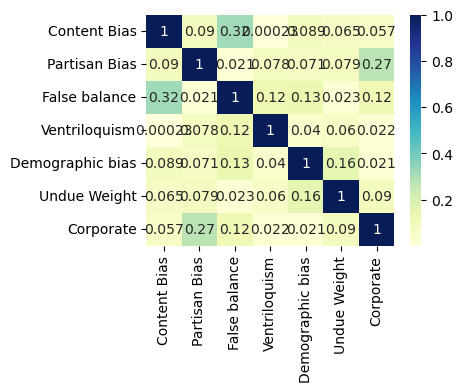

In [25]:
fig = plt.figure(figsize=(4, 3))
corr = sample_dataset.iloc[:, 1:].corr().apply(abs)
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)

this good, we have a decent variance in the data as well.

In [26]:
sample_dataset.iloc[:, 1:].sum() / len(sample_dataset)

Content Bias        0.202838
Partisan Bias       0.178414
False balance       0.124680
Ventriloquism       0.027448
Demographic bias    0.276343
Undue Weight        0.197720
Corporate           0.344499
dtype: float64

In [27]:
sample_dataset.columns

Index(['Sentence', 'Content Bias', 'Partisan Bias', 'False balance',
       'Ventriloquism', 'Demographic bias', 'Undue Weight', 'Corporate'],
      dtype='object')

unbalanced, but it will have to do for now.

a slight detour, for text seperation and then span assignment

In [82]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'
sentarray = np.array(pkt().tokenize(text))
sentspan = np.array([i for i in pkt().span_tokenize(text)])
sentarray.shape[0] == sentspan.shape[0]

True

In [87]:
nlp = spacy.blank("en")
doc = nlp(text)

doc.spans["sc"] = []
for i in range(len(sentarray)):
    doc.spans["sc"].append(doc.char_span(sentspan[i][0], sentspan[i][1], "sentence number " + str(i)))
html = displacy.render(doc, style="span", page=False, minify=False, jupyter=False)
print(html)

<div class="spans" style="line-height: 2.5; direction: ltr">
<span style="font-weight: bold; display: inline-block; position: relative; height: 60px;">
    Lorem
    
<span style="background: #ddd; top: 40px; height: 4px; left: -1px; width: calc(100% + 2px); position: absolute;">
</span>

    
<span style="background: #ddd; top: 40px; height: 4px; border-top-left-radius: 3px; border-bottom-left-radius: 3px; left: -1px; width: calc(100% + 2px); position: absolute;">
    <span style="background: #ddd; z-index: 10; color: #000; top: -0.5em; padding: 2px 3px; position: absolute; font-size: 0.6em; font-weight: bold; line-height: 1; border-radius: 3px">
        sentence number 0
    </span>
</span>


</span>

<span style="font-weight: bold; display: inline-block; position: relative; height: 60px;">
    ipsum
    
<span style="background: #ddd; top: 40px; height: 4px; left: -1px; width: calc(100% + 2px); position: absolute;">
</span>

    
</span>

<span style="font-weight: bold; display: inl

testing ent display

In [86]:
ex = [{"text": text,
       "ents": [],
       "title": None}]

for i in range(len(sentarray)):
    ex[0]["ents"].append({"start" : sentspan[i][0], "end" : sentspan[i][1], "label" : "sentence " + str(i)})

html = displacy.render(ex, style="ent", manual=True, page=False, minify=False, jupyter=False)
print(html)

<div class="entities" style="line-height: 2.5; direction: ltr">
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">sentence 0</span>
</mark>
 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat.
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">sentence 1</span>
</mark>
 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; borde

Back to AI work, this will be used to generate the sentence wise analysis and sent as-is in the JSON. Let's remove the duplicates from our data

In [31]:
sample_dataset = sample_dataset.drop_duplicates().reset_index(drop=True)
sample_dataset.to_csv('./datasets/Filtered_synthesized_dataset.csv')
sample_dataset.head()

,Sentence,Content Bias,Partisan Bias,False balance,Ventriloquism,Demographic bias,Undue Weight,Corporate
0,The president's speech yesterday was an absolu...,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"Climate change is a controversial issue, with ...",0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"In a groundbreaking move, the company announce...",0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,"Despite widespread opposition, the oil company...",1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,The senator's recent tweet demonstrates her un...,0.0,1.0,0.0,0.0,0.0,0.0,0.0


- making a custom class for the sentence embedding layer.

In [32]:
# Load model and tokenizer
model = SentenceTransformer(MODEL_ID)

# Run inference & create embeddings
payload = ["This is a sentence embedding",
           "This is another sentence embedding"]
sentence_embedding = model.encode(payload)

print(sentence_embedding.shape)

(2, 384)


In [33]:
X = model.encode(sample_dataset['Sentence'])
y = sample_dataset.iloc[:, 1:]
X.shape, y.shape

((1846, 384), (1846, 7))

- another detour, making custom tensorboard functions and logs.

In [29]:
# custom class to plot all metrics while learning.
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(21,6))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

model

In [51]:
bias_model = Sequential()
bias_model.add(Input((384)))
bias_model.add(Dense(384, activation='relu'))
bias_model.add(Dropout(0.1))
bias_model.add(Dense(128, activation='relu'))
bias_model.add(Dropout(0.1))
bias_model.add(Dense(32, activation='relu'))
bias_model.add(Dense(7, activation='sigmoid'))
bias_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
bias_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 384)               147840    
                                                                 
 dropout_2 (Dropout)         (None, 384)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               49280     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 201,479
Trainable params: 201,479
Non-tr

In [52]:
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = bias_model.fit(X, y, epochs=50, batch_size=1, shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/50
1846/1846 [==============================] - 12s 5ms/step - loss: 0.3137 - accuracy: 0.3543 - precision: 0.7319 - recall: 0.4051
Epoch 2/50
1846/1846 [==============================] - 9s 5ms/step - loss: 0.2215 - accuracy: 0.4426 - precision: 0.8050 - recall: 0.6181
Epoch 3/50
1846/1846 [==============================] - 10s 5ms/step - loss: 0.1790 - accuracy: 0.4724 - precision: 0.8326 - recall: 0.7117
Epoch 4/50
1846/1846 [==============================] - 10s 6ms/step - loss: 0.1439 - accuracy: 0.4881 - precision: 0.8714 - recall: 0.7790
Epoch 5/50
1846/1846 [==============================] - 9s 5ms/step - loss: 0.1154 - accuracy: 0.4843 - precision: 0.8839 - recall: 0.8316
Epoch 6/50
1846/1846 [==============================] - 9s 5ms/step - loss: 0.0977 - accuracy: 0.4935 - precision: 0.9066 - recall: 0.8561
Epoch 7/50
1846/1846 [==============================] - 10s 6ms/step - loss: 0.0754 - accuracy: 0.4935 - precision: 0.9320 - recall: 0.8913
Epoch 8/50
1846/1846 [=

In [53]:
bias_model.evaluate(X, y, batch_size=1)

1846/1846 [==============================] - 6s 3ms/step - loss: 0.0059 - accuracy: 0.7205 - precision: 0.9942 - recall: 0.9987


[0.00589586840942502,
 0.7204766869544983,
 0.9942324757575989,
 0.9986631274223328]

In [54]:
tf.keras.models.save_model(bias_model, './models/Dense_NN_CURRENT-BEST_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.h5')

now we will start seeing bits of production code, as we get to working on how an example text will be processed

In [3]:
# loading the best model so far
bias_model = tf.keras.models.load_model('./models/Dense_NN_CURRENT-BEST_20230502-190500.h5')

2023-05-02 20:31:39.400840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 20:31:39.403820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 20:31:39.403896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 20:31:39.403923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

In [4]:
# prototype predict function
encoder = SentenceTransformer(MODEL_ID)
def predict_bias(text: str):
    sentarray = np.array(pkt().tokenize(text))
    sentspan = np.array([i for i in pkt().span_tokenize(text)])
    encoded = encoder.encode(sentarray)
    bias_model.predict(encoded)
    return {"predict" : encoded, "render_span" : sentspan}

In [34]:
values = np.arange(0, 0.9, 0.02)
scores = np.empty((0, 4))
for i in values:
    THRESHOLD = i
    binary_pred = (bias_model.predict(X, verbose=False) >= THRESHOLD).astype(int)
    acc = accuracy_score(y, binary_pred)
    pre, rec, fc, _ = precision_recall_fscore_support(y, binary_pred)
    scores = np.vstack((scores, [acc, pre.mean(), rec.mean(), fc.mean()]))
values[scores.argmax(axis=0)]

array([0.74, 0.88, 0.  , 0.78])

In [35]:
THRESHOLD = 0.74
binary_pred = (bias_model.predict(X, verbose=False) >= THRESHOLD).astype(int)
cm = multilabel_confusion_matrix(y, binary_pred)
for i in range(cm.shape[0]):
    print(f"Confusion matrix for class {i+1}:")
    print(cm[i])

Confusion matrix for class 1:
[[1495    3]
 [   0  348]]
Confusion matrix for class 2:
[[1546    0]
 [   1  299]]
Confusion matrix for class 3:
[[1622    0]
 [   1  223]]
Confusion matrix for class 4:
[[1797    1]
 [   0   48]]
Confusion matrix for class 5:
[[1427    1]
 [   0  418]]
Confusion matrix for class 6:
[[1489    0]
 [   3  354]]
Confusion matrix for class 7:
[[1297    0]
 [   0  549]]


In [36]:
metrics_df = pd.DataFrame(scores, columns=['acc', 'pre', 'rec', 'fc'])
metrics_df.describe()

,acc,pre,rec,fc
count,45.000000,45.000000,45.000000,45.000000
mean,0.968424,0.969459,0.998466,0.977168
std,0.147619,0.121621,0.001131,0.105150
min,0.000542,0.173657,0.994799,0.287964
25%,0.989166,0.981791,0.997686,0.990252
50%,0.991333,0.986191,0.999200,0.992555
75%,0.992958,0.994443,0.999200,0.996043
max,0.994583,0.998779,1.000000,0.997480


with threshold and all functions now ready, we can finally work on production code and definitions.

### the end goal is to take text as input 
### and return a sentence wise analysis, 
### both as HTML for the spacy render and as 
### individual final scores

In [37]:
# taking a sample article.
sample_input = """Teachers worried about students turning in essays written by a popular artificial intelligence chatbot now have a new tool of their own.

Edward Tian, a 22-year-old senior at Princeton University, has built an app to detect whether text is written by ChatGPT, the viral chatbot that's sparked fears over its potential for unethical uses in academia.


Edward Tian, a 22-year-old computer science student at Princeton, created an app that detects essays written by the impressive AI-powered language model known as ChatGPT.

Tian, a computer science major who is minoring in journalism, spent part of his winter break creating GPTZero, which he said can "quickly and efficiently" decipher whether a human or ChatGPT authored an essay.

His motivation to create the bot was to fight what he sees as an increase in AI plagiarism. Since the release of ChatGPT in late November, there have been reports of students using the breakthrough language model to pass off AI-written assignments as their own.

"there's so much chatgpt hype going around. is this and that written by AI? we as humans deserve to know!" Tian wrote in a tweet introducing GPTZero.

Tian said many teachers have reached out to him after he released his bot online on Jan. 2, telling him about the positive results they've seen from testing it.

More than 30,000 people had tried out GPTZero within a week of its launch. It was so popular that the app crashed. Streamlit, the free platform that hosts GPTZero, has since stepped in to support Tian with more memory and resources to handle the web traffic.

To determine whether an excerpt is written by a bot, GPTZero uses two indicators: "perplexity" and "burstiness." Perplexity measures the complexity of text; if GPTZero is perplexed by the text, then it has a high complexity and it's more likely to be human-written. However, if the text is more familiar to the bot — because it's been trained on such data — then it will have low complexity and therefore is more likely to be AI-generated.

Separately, burstiness compares the variations of sentences. Humans tend to write with greater burstiness, for example, with some longer or complex sentences alongside shorter ones. AI sentences tend to be more uniform.

In a demonstration video, Tian compared the app's analysis of a story in The New Yorker and a LinkedIn post written by ChatGPT. It successfully distinguished writing by a human versus AI.

Tian acknowledged that his bot isn't foolproof, as some users have reported when putting it to the test. He said he's still working to improve the model's accuracy.

But by designing an app that sheds some light on what separates human from AI, the tool helps work toward a core mission for Tian: bringing transparency to AI.

"For so long, AI has been a black box where we really don't know what's going on inside," he said. "And with GPTZero, I wanted to start pushing back and fighting against that."

The college senior isn't alone in the race to rein in AI plagiarism and forgery. OpenAI, the developer of ChatGPT, has signaled a commitment to preventing AI plagiarism and other nefarious applications. Last month, Scott Aaronson, a researcher currently focusing on AI safety at OpenAI, revealed that the company has been working on a way to "watermark" GPT-generated text with an "unnoticeable secret signal" to identify its source.

The open-source AI community Hugging Face has put out a tool to detect whether text was created by GPT-2, an earlier version of the AI model used to make ChatGPT. A philosophy professor in South Carolina who happened to know about the tool said he used it to catch a student submitting AI-written work.

The New York City education department said on Thursday that it's blocking access to ChatGPT on school networks and devices over concerns about its "negative impacts on student learning, and concerns regarding the safety and accuracy of content."

Tian is not opposed to the use of AI tools like ChatGPT.

GPTZero is "not meant to be a tool to stop these technologies from being used," he said. "But with any new technologies, we need to be able to adopt it responsibly and we need to have safeguards." """


In [52]:
encoder = SentenceTransformer(MODEL_ID)
bias_model = tf.keras.models.load_model('./models/Dense_NN_CURRENT-BEST_20230502-190500.h5')

def predict_bias(text: str):
    sentarray = np.array(pkt().tokenize(text))
    sentspan = np.array([i for i in pkt().span_tokenize(text)])
    encoded = encoder.encode(sentarray)
    predictions = bias_model.predict(encoded)
    assert len(predictions) == len(sentspan), "Something is wrong with your text. I'm not able to split them correctly. Please try again."
    return {"predict" : predictions, "render_span" : sentspan, "text" : text}

sample_res = predict_bias(sample_input)

2/2 [==============================] - 0s 5ms/step


testing numpy magic for indexing

In [39]:
revEncode = sample_dataset.columns[1:]
for i in np.where(np.any(sample_res["predict"] > THRESHOLD, axis=1))[0]:
    Labels = ',\n'.join(revEncode[sample_res["predict"][i] > THRESHOLD])
    print(Labels)


sample_res["predict"].shape

Corporate
Corporate
Corporate
Undue Weight


(37, 7)

In [73]:
# sample script to find label weights
weight = np.sum((np.ceil(sample_res["predict"][np.where(np.any(sample_res["predict"] > THRESHOLD, axis=1))[0]] - THRESHOLD)), axis=0).astype(int)
percentage = (weight / sample_res["predict"].shape[0])*100
total_bias_percentage = (np.where(np.any(sample_res["predict"] > THRESHOLD, axis=1))[0].shape[0] / sample_res["predict"].shape[0])*100
print(weight, percentage, total_bias_percentage)

[0 0 0 0 0 1 3] [0.         0.         0.         0.         0.         2.7027027
 8.10810811] 10.81081081081081


In [105]:
def spacify(spandict: dict, mode: str, isJupyter: bool = False):
    idxs = np.where(np.any(spandict["predict"] > THRESHOLD, axis=1))[0]
    text = spandict["text"]
    sentspan = spandict["render_span"]
    revEncode = np.array(['Content Bias', 'Partisan Bias', 'False balance', 'Ventriloquism',
            'Demographic bias', 'Undue Weight', 'Corporate Bias'])
    options = {"color" : "blue", "line-height" : 3}
    ### SPAN ###
    if mode == "span":
        nlp = spacy.blank("en")
        doc = nlp(text)
        doc.spans["sc"] = []
        for i in idxs:
            Labels = ',\n'.join(revEncode[spandict["predict"][i] > THRESHOLD])
            doc.spans["sc"].append(doc.char_span(sentspan[i][0], sentspan[i][1], Labels))
        html = displacy.render(doc, style="span", page=False, minify=False, jupyter=isJupyter, options=options)
    ### ENT ###
    elif mode == "ent":
        ex = {"text": text,
            "ents": [],
            "title": None}
        for i in range(len(sentarray)):
            Labels = ',\n'.join(revEncode[spandict["predict"][i] > THRESHOLD])
            ex["ents"].append({"start" : sentspan[i][0], "end" : sentspan[i][1], "label" : Labels})
        html = displacy.render(ex, style="ent", manual=True, page=False, minify=False, jupyter=isJupyter, options=options)
    ### FINAL RESULT ###
    weights = np.sum((np.ceil(sample_res["predict"][idxs] - THRESHOLD)), axis=0).astype(int)
    percentages = (weights / spandict["predict"].shape[0])*100
    total_bias_percentage = (idxs.shape[0] / spandict["predict"].shape[0])*100
    return {"total bias percentage" : total_bias_percentage, 
            "individual bias percentages" : dict(zip(revEncode, percentages)), 
            "html" : html.replace('\n', ' ')}

In [106]:
spacify(sample_res, "span", False)

{'total bias percentage': 10.81081081081081,
 'individual bias percentages': {'Content Bias': 0.0,
  'Partisan Bias': 0.0,
  'False balance': 0.0,
  'Ventriloquism': 0.0,
  'Demographic bias': 0.0,
  'Undue Weight': 2.7027027027027026,
  'Corporate Bias': 8.108108108108109},
 'html': '<div class="spans" style="line-height: 2.5; direction: ltr">Teachers worried about students turning in essays written by a popular artificial intelligence chatbot now have a new tool of their own .    Edward Tian , a 22 - year - old senior at Princeton University , has built an app to detect whether text is written by ChatGPT , the viral chatbot that \'s sparked fears over its potential for unethical uses in academia .     Edward Tian , a 22 - year - old computer science student at Princeton , created an app that detects essays written by the impressive AI - powered language model known as ChatGPT .    Tian , a computer science major who is minoring in journalism , spent part of his winter break creating 